# IDEO Homework Assignment
Matt Federighi<br>
Sunday, November 18, 2018<br>
Data Source: https://data.cityofchicago.org/Transportation/CTA-Ridership-L-Station-Entries-Daily-Totals/5neh-572f

Here are my steps when completing the first part of this challenge: 
1. Check the structure of the dataset (data types, size, shape, null values, outliers, etc.). If there are any inconsistencies in the data, develop a plan to clean the data
2. EDA. Explore the features, visualize the data, look for more outliers, and ultimately, get extremely familiar with the data. I like to spend a fair amount of time on EDAs to ensure I know the underlying structure of each feature, how the features interact with each other, and get a string idea for how we can fit a model to the data. 
3. Answer the questions. Once I have a good understanding of the data, it's time to answer the questions

## Importing Data, Checking Data Integrity

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

In [9]:
# Read in Data, convert to datetime
df = pd.read_csv('CTA_Ridership_L_Station_Entries_Daily_Totals.csv', parse_dates=['date'])

# View the DF
print('Data Shape:', df.shape, '\n')
print('Data Info:', df.info(), '\n')
print('Data Description:', df.describe(), '\n')
df.head()

Data Shape: (910136, 5) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910136 entries, 0 to 910135
Data columns (total 5 columns):
station_id     910136 non-null int64
stationname    910136 non-null object
date           910136 non-null datetime64[ns]
daytype        910136 non-null object
rides          910136 non-null int64
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 34.7+ MB
Data Info: None 

Data Description:           station_id          rides
count  910136.000000  910136.000000
mean    40761.518971    3309.313340
std       445.926945    3190.535416
min     40010.000000       0.000000
25%     40370.000000    1122.000000
50%     40750.000000    2319.000000
75%     41150.000000    4350.000000
max     41700.000000   36323.000000 



,station_id,stationname,date,daytype,rides
0,40010,Austin-Forest Park,2001-01-01,U,290
1,40020,Harlem-Lake,2001-01-01,U,633
2,40030,Pulaski-Lake,2001-01-01,U,483
3,40040,Quincy/Wells,2001-01-01,U,374
4,40050,Davis,2001-01-01,U,804


It's strange that the rides variable has a minimum value of 0. That could be for any number of reasons, such as: 
1. The data contains errors / outliers and needs to be cleaned
2. New stations were added / older stations were closed for construction
3. The weather caused some stations to close

Also, the standard deviation for rides seems high. In fact, it's almost the same as the mean for rides. With public transportation we can expect high variability in ridership given that weekends tend to have fewer riders, but this variation seems too high. The high standard deviation could have to do with the 0s in the dataset. We should look further into that before moving onto the next questions. <br>


Below, I am going to create a new dataframe that contains only data on the dates and stations that had zero rides.

In [81]:
# Check the timeframe for the data
print('Start Date of Data:', min(df.date.dt.date))
print('  End Date of Data:', max(df.date.dt.date))

### Filter df to get all rides = 0
zero_rides = df[df['rides'] == 0]

# Print statements
print('\nTotal number of statons in original dataframe:', df['stationname'].nunique(),
      '\nTotal number of stations in the zero_rides dataframe:', zero_rides['stationname'].nunique(), 
      '\nDifference:', df['stationname'].nunique() - zero_rides['stationname'].nunique())

Start Date of Data: 2001-01-01
  End Date of Data: 2018-06-30

Total number of statons in original dataframe: 148 
Total number of stations in the zero_rides dataframe: 97 
Difference: 51


Interesting.. Out of the 149 stations in the dataset, only 51 of those stations have never had 0 rides in a day. This seems strange to me, and it's pretty clear I am missing something. So, let's use our dates feature to visualize the data and see if we can spot any inconsistencies. 

Text(0.5, 0, 'Year')

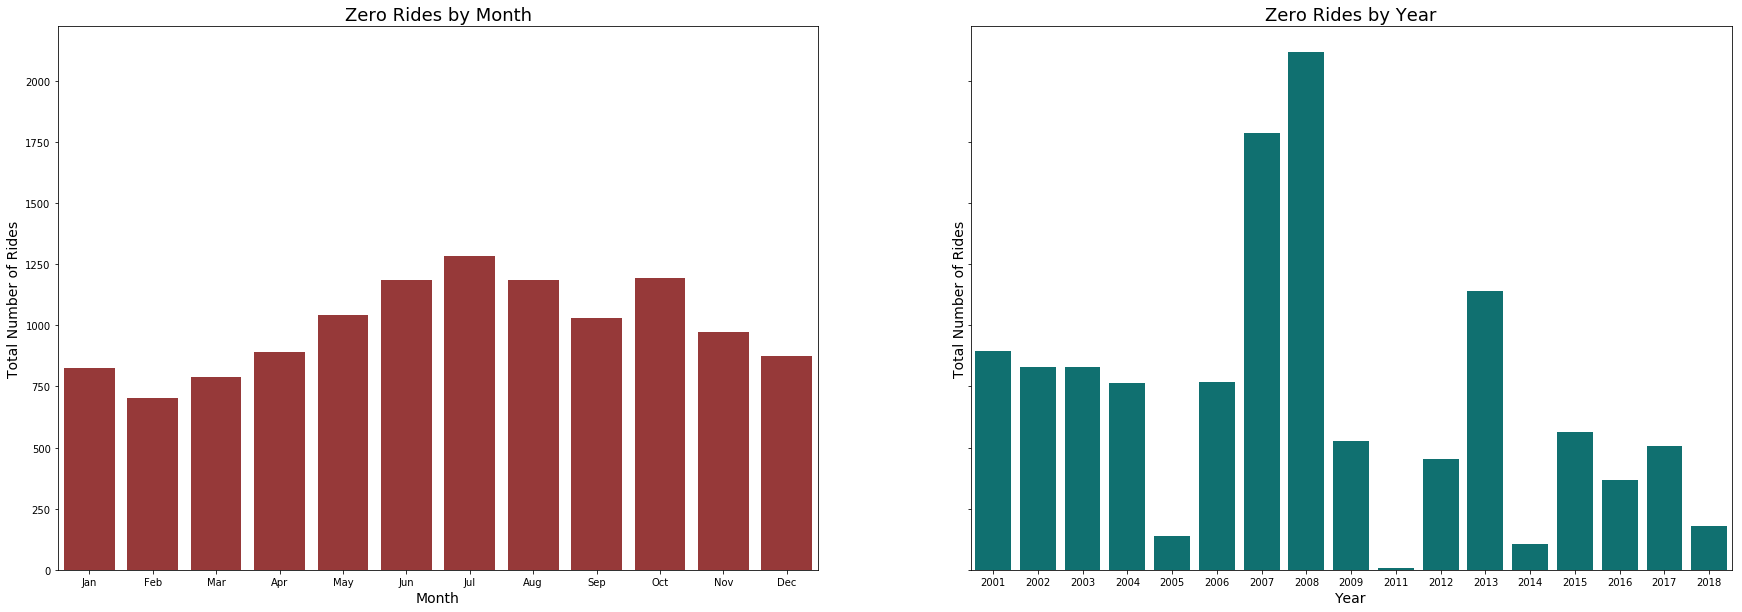

In [184]:
# create df, agg by month, count the number occurrences
zero_rides_month = zero_rides.groupby(zero_rides['date'].dt.month)['rides'].count().reset_index()

# create df, agg by year, count the number occurrences
zero_rides_year = zero_rides.groupby(zero_rides['date'].dt.year)['rides'].count().reset_index()

# Add month name back to dataframe
zero_rides_month['month'] = zero_rides_month['date'].apply(lambda x: calendar.month_abbr[x])

# Plot df
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
fig.set_size_inches(30, 10)
sns.barplot(x='month', y='rides', color='brown', data=zero_rides_month, ax=ax1)
sns.barplot(x='date', y='rides', color='teal', data=zero_rides_year, ax=ax2)

# Labels
ax1.set_title('Zero Rides by Month', fontsize=18)
ax1.set_ylabel('Total Number of Zero Rides', fontsize=14)
ax1.set_xlabel('Month', fontsize=14)
ax2.set_title('Zero Rides by Year', fontsize=18)
ax2.set_ylabel('Total Number of Zero Rides', fontsize=14)
ax2.set_xlabel('Year', fontsize=14)

Aha! What we are looking at above is the number of zero rides aggregated over each month and each year. When we look at the months graph on the left, we can see larger spikes in the summertime. This makes intuitive sense because after a harsh winter with a lot of wind, snow, and rain, the tracks are going to need some maintenance. <br><br>

When we look at the years graph on the right, we can clearly see large spike in 2007, 2008, and 2013. According to sources: 

1. In late 2007, trains were forced to operate at reduced speed over more than 22% of the system due to deteriorated track, structure, and other problems. By October 2008, system-wide slow zones had been reduced to 9.1% and by January 2010, total slow zones were reduced to 6.3%. <br>

2. CTA's Slow Zone Elimination Project is an ongoing effort to restore track work to conditions where trains no longer have to reduce speeds through deteriorating areas. The Loop received track work in 2012–2013. The Purple Line in Evanston received track work and viaduct replacement in 2011–2013. The Green Line Ashland branch received track work in 2013, prior to the Red Line Dan Ryan reconstruction<br>

One more interesting thing to note is that data from 2010 is not shown in the zeros dataset. Given the trends in zero ridership seen above, I'm skeptical that there were no days of zero ridership in 2010. This must be a data cleanliness issue. <br><br>

Now that I feel like I have a good understanding of the data, let's hop into these questions.

## Question 1: Which stop has the highest average ridership per day, and what is it?

In [21]:
# Groupby stationname, aggregate the mean of the rides, sort values & reset index 
highest_ridership = df.groupby('stationname')['rides'].mean().sort_values(ascending=False).reset_index()

# Station shown the most
print('The', highest_ridership.iloc[0,0], 'station has the highest average ridership per day with', 
      max(highest_ridership.rides.values), 'average rides per day')

The Clark/Lake station has the highest average ridership per day with 13900.595837897043 average rides per day


When we look at the map, this makes a lot of sense. It's located in the heart of Downtown Chicago, which is one of the most heavily trafficked areas in the state. When we look back at the data, we see that the Lake/State station (one stop away from Clark/Lake) has the second highest average ridership per day. <br><br>
Note that even when we filtered out all points where riders = 0, the Clark/Lake would still have the highest average ridership. 

## Question 2: What’s the standard deviation for the Washington/Wabash stop? What’s your hypothesis for why?

In [41]:
# Filter for Washington/Wabash station, show the standard deviation for that station
washington_wabash = df[df['stationname'] == 'Washington/Wabash']

# Print the results, round to 2 decimal places
print('Standard Deviation for the Washington/Wabash stop:', str(round(washington_wabash['rides'].std(), 2)))

Standard Deviation for the Washington/Wabash stop: 3525.17


When we look back up at the data description, we can see the standard deviation for the Washington/Wabash station is about 300 rides higher than the sample's standard deviation. Also, the standard deviation for the Washington/Wabash Station is higher than the mean number of rides for the sample. The Washington/Wabash could be an outlier in the dataset. Let's explore this more. 

In [99]:
# Check the timeframe for the data
print('Start Date of the Washington/Wabash Station:', min(washington_wabash.date.dt.date))
print('  End Date of the Washington/Wabash Station:', max(washington_wabash.date.dt.date))

Start Date of the Washington/Wabash Station: 2017-08-01
  End Date of the Washington/Wabash Station: 2018-06-30


We can see right away that the timeframe for this station is less than 1 year. When we check the news, The Washington/Wabash Loop Elevated station, opened August 31, 2017. This is good information, but doesn't quite explain why there is so much variation in the data. Let's go further and look at the data by month and by day of the week. 

Text(0.5, 0, 'Month')

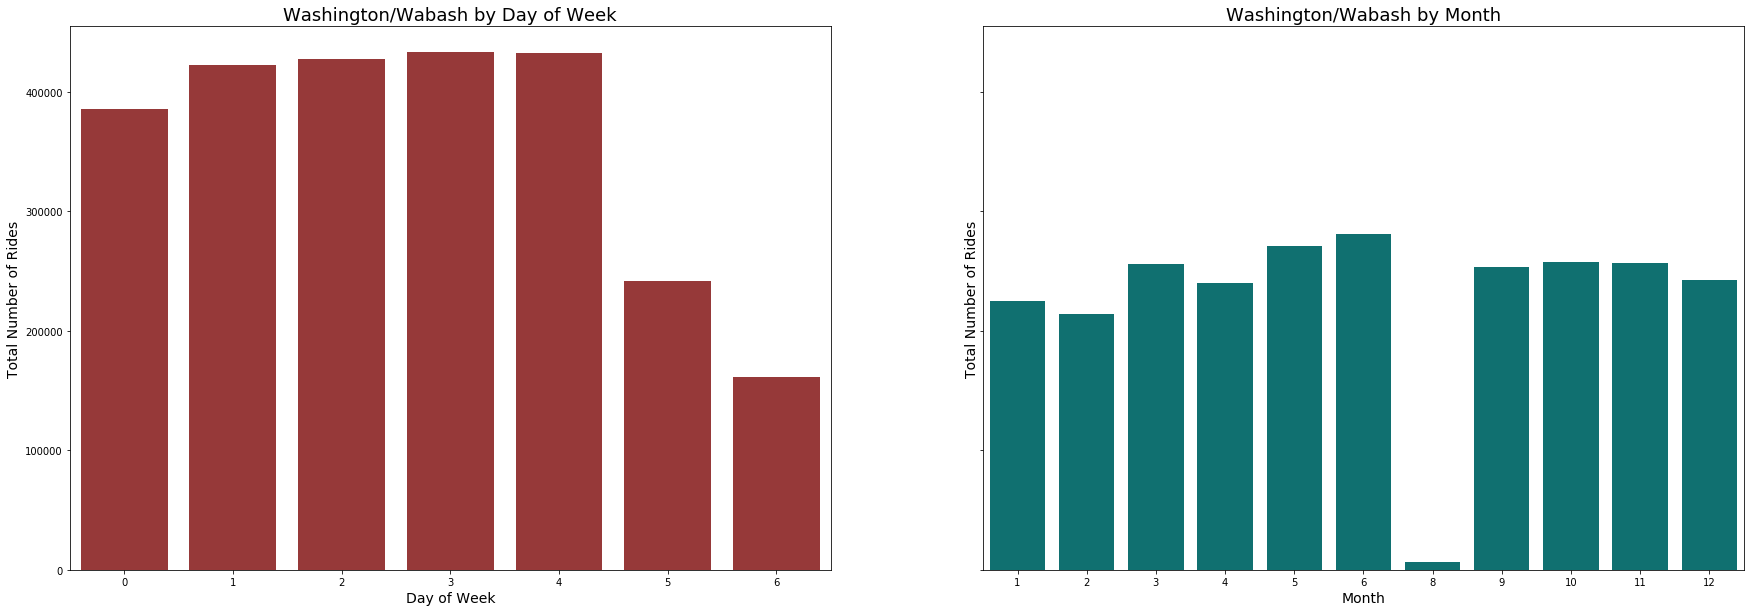

In [182]:
# create df, agg by month, count the number occurrences
washington_wabash_week = washington_wabash.groupby(washington_wabash['date'].dt.weekday)['rides'].sum().reset_index()

# create df, agg by year, count the number occurrences
washington_wabash_month = washington_wabash.groupby(washington_wabash['date'].dt.month)['rides'].sum().reset_index()

# Plot df
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
fig.set_size_inches(30, 10)
sns.barplot(x='date', y='rides', color='brown', data=washington_wabash_week, ax=ax1)
sns.barplot(x='date', y='rides', color='teal', data=washington_wabash_month, ax=ax2)

# Labels
ax1.set_title('Washington/Wabash by Day of Week', fontsize=18)
ax1.set_ylabel('Total Number of Rides', fontsize=14)
ax1.set_xlabel('Day of Week', fontsize=14)
ax2.set_title('Washington/Wabash by Month', fontsize=18)
ax2.set_ylabel('Total Number of Rides', fontsize=14)
ax2.set_xlabel('Month', fontsize=14)

NOTE THAT THE GRAPH ON THE RIGHT IS NOT IN SEQUENTIAL ORDER. <BR><BR>

When looking at the days of the week, we can see some drop off when it Saturday and Sunday come around and this is to be expected. Nothing too exciting here.<br><br>
The real reason why the standard deviation for the Washington/Wabash station is so high is due to the station opening on August 31, 2017. This means for the month of August. we only had 1 day of ridership. Since we have less than 1 year's worth of data for this station, that single day has significant impact on the standard deviation. To get a true reading on the standard deviation, we should start the time frame on 9/1/2017. Let's do that below. 

In [186]:
# Create new DF. Date must greater than 9/1/2018. 
washington_wabash_filtered = washington_wabash[washington_wabash['date'] > '9/1/2017']

# Calculate the Standard deviation, round to 2 decimals
print('True Standard Deviation for the Washington/Wabash stop:', str(round(washington_wabash_filtered['rides'].std(), 2)))

True Standard Deviation for the Washington/Wabash stop: 2753.25


While 2753.25 still seems slightly high, it's a significant improvement from our previous standard deviation of 3525.17. 

## Question 3: The Challenge Question
Please choose a specific business and tell us which business you chose; any kind of business will do. Imagine you’re helping that business owner in Chicago and s/he is looking to open a new location. In the form of writing, potentially supplemented by sketches (computer-drawn or hand-drawn) and links, we want to see your response to these questions:

- What questions could you potentially explore/answer with this data?
- Ideally, what other data would you gather or combine to learn even more?
- How would you want to see data presented, to make it actionable by you or others?
- How could an algorithm or model be used? How might your client interact with that algorithm or model?

Furthermore, we want to see the results of 2–3 hours of work, using the real data, towards making those ideas a reality. The results could include findings from the data, code, Python/R notebooks, a visualization, results of a statistical model you built, etc. Try not to hide things or throw them away— we want to see your work!

##### Some additional guidelines
- We're not expecting perfection here; this is intended to be something you spend an afternoon or so on. Send us whatever you used to tackle the problem, even if it’s not pretty.
- You're not required to use any specific tools— pick your favorites. Colored pencils are just as valid as d3. Think of this as an opportunity to showcase your strengths.
- Feel free to aggregate or filter the data however you see fit— if you want to focus on a particular train line, time period, season, stop, neighborhood, etc, go for it. "Big Data" isn't necessarily going to impress us more than a thoughtful approach or interesting findings from a small slice, especially if that aligns with the story you’re telling.

##### Why are we doing this?
This challenge is not all that different from what happens at the beginning of a project at IDEO. We have to go from large amounts of ambiguity to valuable work in short periods of time, and we do it by empathizing with the needs of our client, imagining what’s possible, selecting the most promising ideas, and working swiftly and iteratively to share our work early and build towards the bigger ideas. If you find this fun, you’re going to like it here.
<br><br>
This also gives you an opportunity to show us what you’re capable of; this is what we do instead of unrealistic and unreliable whiteboard coding interviews. And afterwards, you’ll have a little data project to add to your portfolio that you can build on further if you want to.
<br>
_____________________________________________________________

## Part 1: Define the Business, Brainstorm the Path

### Scenario: 
The Data Nerds, LLC is a data science & analytics consulting firm based in Chicago, IL. The Data Nerds have been in business for 5 years and have seen significant business growth since their launch in 2013. One of the founders (Christina) recently moved to the San Francisco Bay Area to be closer to her family, and is exploring the idea of opening a new branch. Christina loves her job as a Data Science consultant and enjoys working with her co-founders, so she is looking for an opportunity to grow the firm's presence in the San Francisco Bay Area. Christina wants to hit the ground running when she makes the move and has asked for help to understand the market in San Francisco for analytics consulting firms. In the following pages, we will explore the opportunities for Data Science & Analytics consulting firms in the San Francisco Bay Area and determine if starting a new branch of The Data Nerds is a smart investment.<br>
<br>
**Problem Statement**: Should The Data Nerds open a new consulting branch in San Francisco, CA? <br>
<br>
**Goals of the analysis**
We want to answer questions like:<br>
- Should The Data Nerds open a new consulting branch in San Francisco, CA? Are there other cities that would be a better fit? 
- Let's compare Chicago to San Francisco. Is there a major difference in industries and business types? Is there overlap? Can we mimic Chicago's execution in San Francisco?
- How many Data Scientists / Analysts / Engineers are currently employed in San Francisco? How many are unemployed?
- Is there a need for data scientists in San Francisco? Or is the market oversaturated? 
- Has there been a demand for data science consultants in San Francisco? If so, what types of companies are looking for help?
- What is the supply for data scientists in San Francisco? Are there more technical degrees at the local universities? Are there more student enrolled in STEM programs? 
- Looking at Google search results, has data science as a topic increased in popularity? Are people searching for data scientists on google? What are people looking at? 
- What industries are in San Francisco? Which industries are most susceptible to advances in technology? Should we target those industries? Or should we look at tech companies? 
- What is the cost of owning and running a business in San Francisco? What are the costs for office spaces? Hiring talent? Taxes & business licence fees? 
- Is it feasible to open a new consulting firm in the Bay Area with limited funds and no customer list? 
- How do we grow our business? Should we sponsor Meetups? Host events? Partner with other orgnizations in the area? Paid advertising? 
- How do we attract top talent? What is the supply and demand for data scientists? How much money does a Data Scientist expect to earn?
- Who is the ideal client? Who is the anti-client? 
- What types of business tend to adopt data science practices? Do they prefer to hire talent or hire consultants? 

**Before diving into a solution, we need to get more information from The Data Nerds & Christina**:<br>
From the description above, we know that the high-level question is: should The Data Nerds open a new branch in San Francisco, CA? But, we need to dive deeper into that question to get a comprehensive view of The Data Nerds business, specialities, and ultimate goals for the expansion. Below is a small sample of discovery questions that will help us get a clearer picture of The Data Nerds. <br>
1. *What type of work do The Data Nerds do? Do you have any specialties or unique traits?*<br>
    The Data Nerds are a Strategy, Consulting, Development, and Training organization that helps companies better understand their data. The Data Nerds work with companies to better understand their data and help develop an execution plan. Their specialty and unique trait is human-centered design. Human-centered design is all about building deep relationships with the people we're designing for to help us get a strong understanding of their business needs and turning those ideas into innovative solutions. At our core, The Data Nerds are focused on solving the problems our customers face, using creative and practical implementation methods. 
    
2. *Of those areas, which drive the most business? Which are weak links to the business?* <br>
    Strategy & Consulting are definitly at the forefront of our business. Our customers want to be data people, but they may have had a hard time finding that unicorn who can lead them to ultimate success. That's where we come in, helping companies of all types leverage their own creativity and resources to build scalable and lasting solutions that align with the goals of the business. 
    
    Our weak link is training. While training is arguably the most important part of any consulting project, its not the most exciting and innovative piece of the puzzle. We pride ourselves in creating training programs that truly stick with the end-users, and training plays a role along every stage in the project. However, selling training services as "Training" has not gained the traction we would like it to. 
    
3. *If you could start over with The Data Nerds, what would you do different?* <br>
    Focus on methodology from the beginning. It took us quite some time to develop our methodology and uniqueness, and it's by far the most important piece of our business. We can hire thousands of sales people and get an endless supply of projects, but at the end of the day a consulting firm is only as good as their people and methodologies. You can land the largest projects in the world, but if you can't connect with your stakeholders and understand their true goals, then the project is destined for failure and dissatisfaction from the customer. In the beginning, we were focused on landing the big client names and on the technical methods of Data Science. The missing piece in the early days was developing a methodology that allowed us to truly connect with our customers and deliver solutions that aligned with their business goals. 
    
4. *Why do you think there's a need for a Data Science Consultancy? What's the source of that problem?*  <br>
    Generally speaking, people are scared of mathematics and are easily overwhelmed by the amount of data in front of them. As an beginner, you can get easily get lost in the data and completely lose track on your end goal. Often times we see people focusing on specific Data Science methods instead of tangible solutions, and that leads to extreme inefficiencies in the process. That's where we come in. We've been lost in that data before, and we know how overwhelming it can get. We use that experience to keep you focused on the end goal and lead you in the direction of success. At the end of the day, each stakeholder has different business goals and wants to be heard. So, we help your company achieve it's goals with the power of human-centered design and data science. 

5. *What would a successful outcome look like to you?*<br>
    A successful outcome to us is a happy customer. We need profits and cash-flow to keep the business going, but ultimately we want our customers not only to succeed, but to become industry leaders. Each company that hires us has passion and dedication to achieve their business goals, and we empower that company so they can take complete control of their operations. We like to see customers that are eager to learn from us, are open-minded to our creative approach, and willing to participate. Our goal is not to complete a project and move onto the next customer. Our goal is to deliver so much value to the customer that they change the way they think and build that confidence that will ultimate lead them to success. 

6. *Who is your ideal customer? What does that relationship look like?*<br>
    An ideal customer is someone who is eager and willing to learn, a customer who is patient, and a customer who knows what they want. Clear communication is absolutely necessary in this process, and we want to keep all forms of communication open. Our ideal customer will lean on us for support, they will push back on us when they feel something is off, and they will take their control of thier business. We like when customer are open and honest. If something's not right, tell us. If we're moving to fast or too slow, tell us. We want to ensure our customers are successful, and we will take great lengths to ensure our services are providing extreme value. 

7. *What are your primary roadblocks to implementing this plan?*<br>
    Right now, our biggest road block is openining a new branch. We have the capital, but opening a new branch is always a risky business decision. This is why we are conducting a thorough market analysis is key. We want to know the supply & demand of both jobs & talent, the opportunites for growth, the potential risks, and how we can mitigate those risks to ensure we have a successful launch. 

8. *What would happen if you decided to take a Data Scientist job elsewhere instead of starting a new branch? Why take on such a big risk?*<br>
    We see an opportunity to change the way companies use Data Science to solve business problems. Data Science has become an established career over the last few years, but we still see many companies doing it wrong. We're taking this risk because we belive a human-centered approach to data science & design can truly change the way a business operates and impacts the community around them. Right now is a perfect opportunity to establish ourselves as industry leaders and create a lasting impact on businesses and people. We want to inspire, create, and innovate with our customers and our employees. 

9. *What is your experience with running a team of Data Scientists & Analysts? Would you want to be hands-on or do you want to run the team?* <br>
    I've been running teams of Data Scientists & Analysts for approximately 5 years. In that time, I've learned a lot from the people I've worked with and understand how to set people up for success. My experience has allowed me to change my perspective and look at problems from a different angle, and that's the main reason I want to be a hands-on leader. Ultimately, my goal is to lead our employees to success and ensure our customers have an outstanding experience with our services. 

10. *How committed are you to this plan? How excited are you?*<br>
     100% committed and 150% excited! This is a big undertaking starting a consulting business in a new city, but I'm extremely excited for the challenge and committed to do whatever it takes to ensure we have a successful launch. 



**Summary & Constraints**:
- Christina has never been to San Francisco and needs a local to help her understand the opportunities out here. 
- The work is San Francisco-based only and is to be completed on-site (no remote work)
- Assuming Christina cannot land a single client, she has enough capital to cover all expenses for 6 months
- Christina has no data for us, and we need to compile our own data to showcase
- Christina wants to spend 50% of her time running the business and 50% of the time working on projects (this will be challenging, but it could work because she is a small business)

### What questions could you potentially explore/answer with this data? 
The first and most important point is that there is never a single, clean source of data that will give you all the answers. We will need to explore multiple datasets in this challenge. Once we find some data sources, here are some questions I'd like to explore. 

Demand
- Is there a demand for Data Scientists & Analytics consulting in the San Francisco Bay Area?
- Has there been a spike in the demand for data science & analytics positions?
- How many other data science consulting firms are located in the San Francisco Bay Area? 
- What are the dominant industries in the San Francisco Bay Area? Can data science firms help these industries?
- What is the general attitude towards Data Science? Can this be measured?
- What does the professional services industry look like? It is growing or shrinking? Do people prefer to hire full time or contract to consultants? 

Supply
- How many data scientists / analysts / engineers in the San Francisco Bay Area? 
- What are their skills sets? What industries do they specialize in? 
- Are companies hiring for Data Scientists? If so, what types of companies are hiring? Whay types are not hiring? 
- Does demand exceed supply? Does supply exceed demand? Either way, how do we attract top talent?  
- How many universities offer Data Science & Analytics programs? Can we estimate the labor force for Data Scientists? 
- What about bootcamps? Are there well-known Data Science bootcamps? 

Economic Indicators
- Has employement been rising or falling?
- Has the average wage been rising or falling?
- How many new jobs were created last year? Last 6 months? Last 3 months? 
- What types of jobs are on the rise? What ypes of jobs are on the fall? 
- Have housing prices been rising? Is this a sign of new wealth moving into new areas (gentrification)? How does that impact business?
- What are the projections? Will employement rise or fall? 

Compare Chicago to San Francisco
- Are there major differences between business types? Similarities? 
- How do demographics differ? How are they similar? 
- What types of projects in Chicago? Could we mimic those projects in San Francisco? 
- What about demand? Can we use the same business model in both cities? 
- What works well in Chicago? What doesn't? Can we avoid the same problems in San Francisco? 
- What about the industries and wealth? Are businesses willing to spend more money in either city to attract top talent? 

Operational Costs
- What does it cost to hire a full-time, Senior data scientist in San Francisco? 
- How much are office spaces in San Francisco? Do we need an office? 
- What about taxes, business fees, licensing, legal counsil, etc.? Can we operate efficiently? 
- How can we handle attrition? What are the costs of hiring and training a new employee? 

Competition
- Who is the competition? Are they actually competition?
- Is the competition other consulting firms? Or is the competition companies that are not looking for outside consulting help? 
- Can we compete? Are these other firms backed by venture capital? Can we get backed by venture capital? How many venture capital firms are in the area? 

### Ideally, what other data would you gather or combine to learn even more? 
Census data
- Population, demographics, education levels, public health, income, business data, etc. 
- Census data allows us to explore San Francisco as a whole and get an understanding of people's attitudes towards consulting businesses
- It also allows us to better understand our target demographic
    
Job and Project Demand
- We can scrape data from job sites (LinkedIn, Indeed, Monster, etc.) and pull relevant information from the sites. 
- This could get computationally expensive, but the knowledge of the job market can help us predict revenue & demand. 
- In addition, this is a great way to start conversations with these companies. If we see a company is hiring 2-3 data scientists, we can contact the company and start a conversation
- State of the industry reports. What's going on in specific industries and how we can use our expertise to tap into those industries? 

Job and Project Supply
- By looking at the current labor market, we can gauge how many data scientists / analysts / engineers are currently in the market. 
- In addition, we can get information from local universities on the number of students graduating with technical degrees. This can help us forecast future supply. 
- Information on San Francisco's job market. Since we've seen an influx in projects in the San Francisco Bay Area, we can analyze this data to get an idea of the types of companies and projects that are looking for Data Scientists.
- What projects are companies working on? Companies like Salesforce & Oracle have large market shares in the Bay Area. How can we leverage that? 

Marketing Statistics
- What marketing activites generate the most business? 
- Should we look at LinkedIn advertising? Creating groups on Meetup? Frequently ttending networking events? What other social media platforms? 
- What are the optimal times for cold calls? Cold emails? 
- How do we market ourselves to potential talent? We want to have top-notch consultants, and we want to ensure they are excited about our work. 
- What is the potential for new grads? Is it worth targeting new grads? What is the ROI for on-campus events & presentations? 
- How do we leverage any marketing materials from our Chicago office? Were those materials effective in the Chicago office? Will it be effective in San Francisco? 

What we can't get: 
- Since this is a scenario, we cannot get data from our Chicago office. This would have been extremely helpful. 
- Detailed information on our competitors. While we can gather some high level data, we cannot see the types of projects they're working on or their rates. 

### How would you want to see data presented, to make it actionable by you or others?
From a business perspective, I'd want to see the data presented in multiple forms. I would start off by showing the customer visualizations that ultimately meet their business needs. In this case, I'd want to show numerous items such as: 
- Statistics & Metrics on how close we can get to meeting our ultimate goal. If our goal is 100% growth over the next 2 years, we need to ensure that is at the front and center. If we are shy of that goal, how can we make up that gap? Is our goal unreasonable or are we looking at the problem in the wrong way? 
- Demand trends for projects and hiring. Graphs showing that demand is increasing for both, and projections over the next 3-5 years. If demand for data scientists is increasing, are businesses looking to hire consultants to help develop their data practices? Or does the data show that companies are hiring full time employees? 
- Supply trends for projects and hiring. Graphs showing that the supply of data scientists is increasing, but it's not oversaturating the market. If oversaturation occurs, then we need to figure out how to establish outselves faster to ensure we can make it through the saturation periods. In addition, I'd want to see projections for the market over the next 3-5 years. Will this industry even exist? Will is be thriving or declining? etc. 
- Interactice dashboards and reports. Ultimately, our clients know their businesses better than we do. Therefore, we want to present them with interactive dashboards and reports after we present our findings. This will allow them to explore the data firsthand and search for patterns and trends that we could have missed. In addition, it builds confidence for the customer, showing them that they can take control of their business. 
- Pitfalls. In addition to all the positives, I want to see risks and potential negative outcomes. We need all sides of the story to be presented so we are completely prepared for any curveballs that are thrown at us. If we predict that there will an oversaturated marked in 2 years, let's start planning right now to ensure we can get through that period smoothly. We want to be proactive, not reactive. 


From a technical standpoint, I would like to know how we aggregated the data, how we dealt with missing data points, outliers, etc. The methodology is extremely important when predicting outcomes (such as supply and demand of a market), so we need to make sure our methodology is sound. Also, I would like to see more technical visualizations here. Clustering outcomes, decision tree outcomes, model scores, ROC curves, etc. Again, I want to stress our methodology to ensure we are being as accurate as possible. Most of this is implied when hiring experts, but interally I would like to ensure our team is making the correct decisions. Also, some of our customers are going to be technical and that's great! We need to keep them on track and ensure we are focusing on the business goal, but the technical details do matter in these projects. 

### How could an algorithm or model be used? How might your client interact with that algorithm or model? 
Predict Supply & Demand on multiple levels: 
- We can predict the demand of the market (both hiring and for potential projects). Our model can tell us what the predicted demand will be for a given problem and give us insights on the shoertcomings. We can show this in Tableau, D3, etc. and allow the client to change filters & parameters to get the information they are looking for
- We can also predict the supply of talent & projects. If market demand for data scientists continues to increase, we can make predictions as to how many additional consultants will be needed to meet that demand. We can also look at how companies are growing and the number of new companies coming into the market every year. 

Forecasting Revenues. 
- With the supply and demand information, we can predict our revenues, which will help us plan our budgets for the coming months / quarters / years. 
- Forecasting revenues will also allow us to make strategic investments. Whether that's developing new programs, hiring more talent, investing in our infrastructure, or sponsoring major events to show that we are the industry leaders. 
- Interactive dashboards are a great solution here. There will most likely be multiple stakeholders in the room for these presentations, so being able to dynamically product reports in these meesting will provide significant value. 

Forecasting efficiency
- We can forecast efficiency by looking at our consultant's utilization as well as our project budgets. Are we constantly going over budget? Is our team underutilized? How do we get them more projects? How do we minimize the project transition periods?
- Most of these questions can be answered once we get a good reading on our consultant's and project's efficiency. 

Optimal teams for ultimate efficiency on projects. 
- Not all people are meant to work together. However, we can optimize our team selection process to ensure our projects are efficient our customers are satisfied. 

## Part 2: The Results

### Let's Start with the Data Science Job Market
Data Science Job Market: 
https://www.kaggle.com/sl6149/data-scientist-job-market-in-the-us<br><br>
A few things to note.. This data was scraped from Indeed.com on August 3rd, 2018 from someone named Shanshan Lu. While Shanshan gave us a free dataset in Kaggle, I have not looked deeply into his methods of scraping the data and I cannot confirm its accuracy. There could be some errors and there could be missing information. In addition, the dataset is out of date, there are countless other job sites out there (LinkedIn, Monster, Google for Jobs, Glassdoor, Career Builder, etc.) and this dataset is not a perfect representation of the job market today. In a real-world scenario, we would want historical data that shows job postings over the last few years so we can see the trends and predict future demand. We'd also (most likely) need to pay for data like this. <br> <br>
Although this is not a perfect dataset, I felt this was good enough to show my thought process and ability to analyze data. 

In [59]:
# Read in Data
job_market = pd.read_csv('alldata.csv')

# View the DF
print('Data Shape:', job_market.shape, '\n')
print('Data Info:', job_market.info(), '\n')
job_market.head()

Data Shape: (6964, 5) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6964 entries, 0 to 6963
Data columns (total 5 columns):
position       6953 non-null object
company        6953 non-null object
description    6953 non-null object
reviews        5326 non-null float64
location       6953 non-null object
dtypes: float64(1), object(4)
memory usage: 272.1+ KB
Data Info: None 



,position,company,description,reviews,location
0,Development Director,ALS TDI,Development Director\nALS Therapy Development ...,NaN,"Atlanta, GA 30301"
1,An Ostentatiously-Excitable Principal Research...,The Hexagon Lavish,"Job Description\n\n""The road that leads to acc...",NaN,"Atlanta, GA"
2,Data Scientist,Xpert Staffing,"Growing company located in the Atlanta, GA are...",NaN,"Atlanta, GA"
3,Data Analyst,Operation HOPE,DEPARTMENT: Program OperationsPOSITION LOCATIO...,44.0,"Atlanta, GA 30303"
4,Assistant Professor -TT - Signal Processing & ...,Emory University,DESCRIPTION\nThe Emory University Department o...,550.0,"Atlanta, GA"


In [100]:
# General information
print('Number of unique open positions:', job_market['position'].nunique())
print('Number of unique companies hiring:', job_market['company'].nunique())
print('Number of unique cities:', job_market['location'].nunique())
print('\n')
# Let's groupby position, get the counts, sort df
position_counts = job_market.groupby('position')['company'].count().sort_values(ascending=False).reset_index()

# View the head
position_counts.head(10)

Number of unique open positions: 5242
Number of unique companies hiring: 2213
Number of unique cities: 382




,position,company
0,Data Scientist,351
1,Senior Data Scientist,96
2,Research Analyst,64
3,Data Engineer,60
4,Machine Learning Engineer,56
5,Lead Data Scientist,31
6,Research Scientist,30
7,Sr. Data Scientist,28
8,Principal Data Scientist,24
9,Software Engineer,22


One thing we notice here is the number of variations for a given position. Data Scientist, Sr. Data Scientist, Senior Data Scientist, etc. We can also see there are some issues with the location. For example: Atlanta, GA 30301 and Atlanta, GA should be the same, but if we aggregate then they will be counted as unique cities. Therefore, the number of cities in this dataset is not actually 382. Before we gain any real insights from this dataset, we need to clean up the dataset. <br>

First, I am going to clean up the location column. <br>
Then, I am going to create new columns for the different roles. <br>
After that, we are going to split our results and see which city has the highest demand. 

In [253]:
# First, let's clean up the locations
# Create new DF
new_df = job_market.copy()

# Lowercase the entire DF
new_df = new_df.apply(lambda x: x.astype(str).str.lower())

# Split at the city
city = new_df['location'].str.split(",", n = 1, expand = True)

# Create new column for that city
new_df['city'] = city[0]

# drop old location & reviews
new_df = new_df.drop(['location', 'reviews'], axis=1)

# Print number of unique cities
print('Number of unique cities in clean dataset:', new_df['city'].nunique())

Number of unique cities in clean dataset: 92


In [254]:
# Now let's fix the position column
# Create new columns for position types. Note that we do not have an "other" column because it's redundant
new_df['data_scientist'] = new_df.position.str.contains('data scientist').astype(np.int8)
new_df['analyst'] = new_df.position.str.contains('analyst').astype(np.int8)
new_df['engineer'] = new_df.position.str.contains('engineer').astype(np.int8)
new_df['manager'] = new_df.position.str.contains('manager').astype(np.int8)

In [255]:
# Finally, let's group this dataset and plot the results. Note that we do not have an "other" column because it's redundant
city_df = new_df.groupby('city').agg({'data_scientist': 'sum',
                                      'analyst': 'sum',
                                      'engineer': 'sum',
                                      'manager': 'sum',
                                      'position': 'count'}).sort_values(by='position', ascending=False).reset_index()

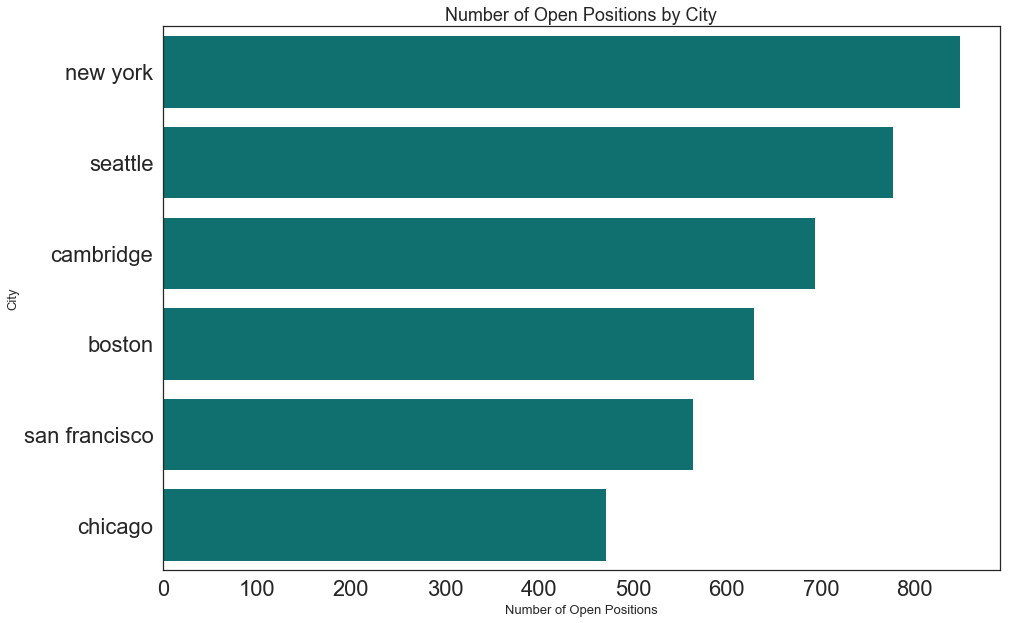

In [238]:
# Plot overall positions by city
sns.set_style('white')
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(city_df['position'], city_df['city'], color='teal')
plt.ylabel('City', fontsize=13)
plt.xlabel('Number of Open Positions', fontsize=13)
plt.title('Number of Open Positions by City', fontsize=18)
plt.show()

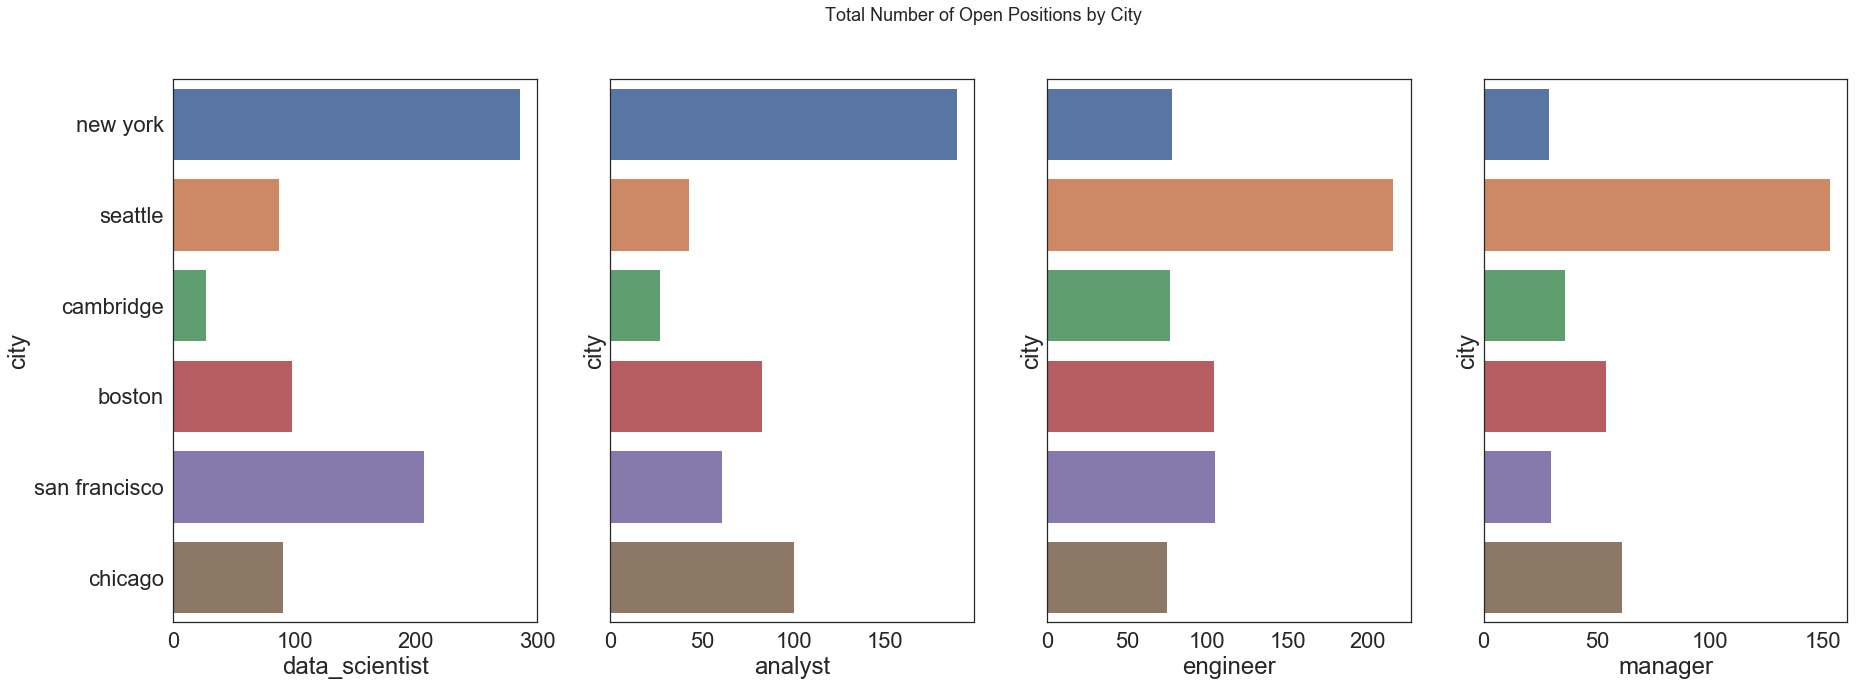

In [237]:
# Plot aggregated positions by city 
sns.set_style('white')
f, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, sharey=True, figsize=(30, 10))
plt.xticks(rotation='horizontal')
sns.barplot(city_df.data_scientist, city_df.city, ax=ax1)
sns.barplot(city_df.analyst, city_df.city, ax=ax2)
sns.barplot(city_df.engineer, city_df.city, ax=ax3)
sns.barplot(city_df.manager, city_df.city, ax=ax4)
plt.suptitle('Total Number of Open Positions by City', fontsize=18)
plt.show()

The first plot tells us that in terms of overall jobs, New York has the most open positions available. San Francisco ranks 5th on this list and Chicago is ranked 6th.<br>

When we look at the second plot, we can see than San Francisco is ranked second in Data Scientists and Engineers. New York has the most Data Scientists and the most Analysts by far. <br>

When we compare Chicago to San Francisco, we can see that the demand for Data Scientists & Engineers is higher in San Francisco. This is a good thing because it shows that there is a demand for Data Scientists and Engineers in San Francisco. This is exactly what we wanted to see. I expected San Francisco to rank the highest among all cities, so it's interesting to see different. <br>

One final thing to look at is the companies in San Francisco that are looking for these positions. 

In [256]:
new_df.head()

,position,company,description,city,data_scientist,analyst,engineer,manager
0,development director,als tdi,development director\nals therapy development ...,atlanta,0,0,0,0
1,an ostentatiously-excitable principal research...,the hexagon lavish,"job description\n\n""the road that leads to acc...",atlanta,0,0,0,0
2,data scientist,xpert staffing,"growing company located in the atlanta, ga are...",atlanta,1,0,0,0
3,data analyst,operation hope,department: program operationsposition locatio...,atlanta,0,1,0,0
4,assistant professor -tt - signal processing & ...,emory university,description\nthe emory university department o...,atlanta,0,0,0,0


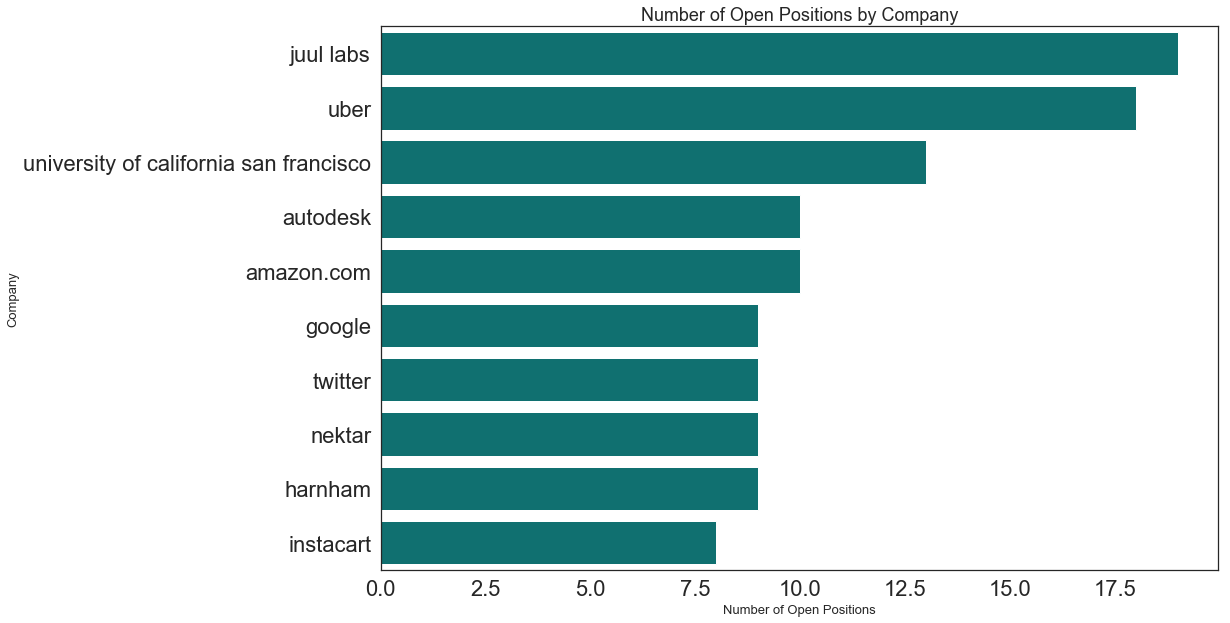

In [270]:
# Filter to San Francisco only
sf = new_df[new_df['city'] == 'san francisco']

# Create grouping by city, limit to 10
sf_companies = sf.groupby('company')['position'].count().sort_values(ascending=False).reset_index()[:10]

# Show the top companies looking for talent
sns.set_style('white')
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(sf_companies['position'], sf_companies['company'], color='teal')
plt.ylabel('Company', fontsize=13)
plt.xlabel('Number of Open Positions', fontsize=13)
plt.title('Number of Open Positions by Company', fontsize=18)
plt.show()

With the exception of UCSF, the companies with the most open positions are tech companies. This is extremely useful because it will allow us to focus our marketing and lead generation efforts on tech companies. 

### General Trends

Google Trends is a great way to get an idea of topic popularity over time. The UI gives you many options to filer & explore the dashboards. <br><br>
I first started with a quick search with of terms in the San Francisco Bay Area on 'Data Science' as a search term (blue), 'Data Science' as a field of study (red), and 'Data Scientist' as a search term (yellow). This data spans over 5 years and below is what we find. 

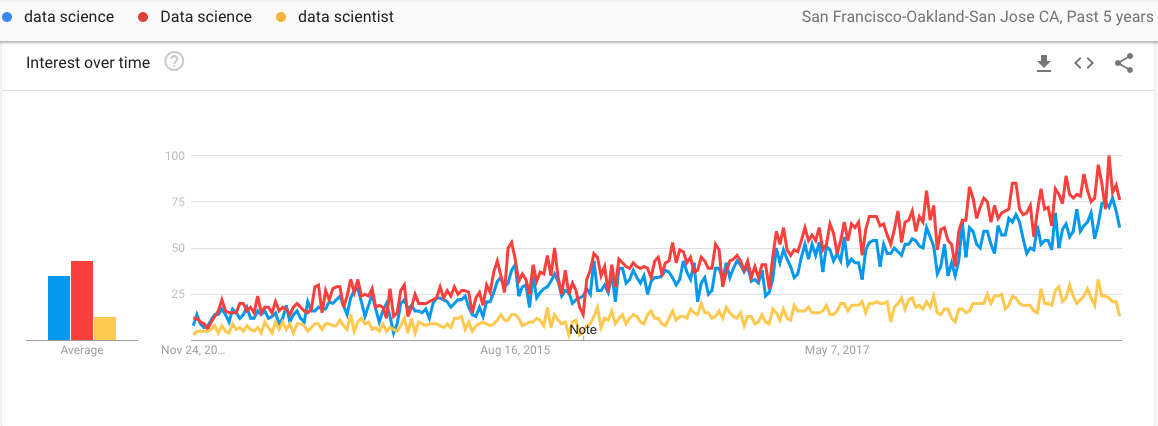

In [5]:
# Import Packages & Show image
from IPython.display import Image
Image(filename = path + "GoogleTrends1.png", width=1000, height=1000)

https://g.co/trends/TV67Y <br><br>

When we look at the "Related Queries," we find the following: 
1. data science berkeley
2. data science jobs
3. data scientist
4. stanford data science
5. uc berkeley data science

One of the great things about Google Trends is its flexibility. We add numeroud filters, looking in specific industries and fields to see which fields have the most traction and interest. We can see related search terms that allows us to narrow our search even further, and it gives us a general idea of how data science is accepted in the city. To me, it's pretty clear that Data Science is on the uprise and there has been significant interest in the subject. We also see that colleges are high on the top-related search terms, which means the education system has begun adopting data science as a field of study. Intuitively, this could mean that the supply of Data Scientists is going to rise siginificantly over the next few years.

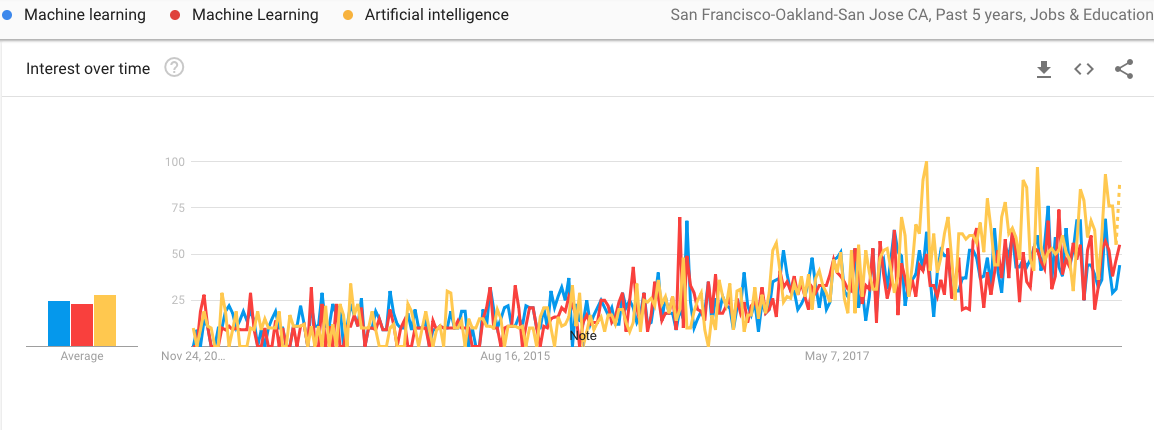

In [35]:
Image(filename = path + "GoogleTrends2.png", width=1000, height=1000)

https://g.co/trends/sJvFA <br><br>

Another hot topic in Data Science is Machine Learning. Keeping the parameters the same (5 years time and limited to San Francisco Bay Area only), we can clearly see an upward trend in machine learning as a field of study (blue), as a search term (red), and artificial intelligence. Even though machine learning and artifical intelligence can be considered buzz-words, this is still really exciting for us! Executives and Decision Makers have most likely heard the terms and read about the power of such methodologies, so this could allow us to quickly tap into markets & industries.  

When I added search terms such as 'Data Science Consultant,' 'Data Science Design,' and 'Data Science Strategy,' there was not enough data to give us results. So, measuring demand of data science projects is going to be tough, but doable. We will just need more specific data related to company goals and industry trends. If we begin to see shifts in industries moving to Data Science & analytics-based approaches, that would be an excellent opportunity for us to target those industries. 

In addition to the search results from Google Trends, below we will find a graph from Statista that shows the growth in the consulting market from 2015 to 2017 in Billions of dollar. We can see clear, upward growth for the consulting market in the US, which is great news for our new consulting business. However, this does not look at San Francisco data only. We would need to pay for that data to get more detailed and targeted information on the consulting market. 

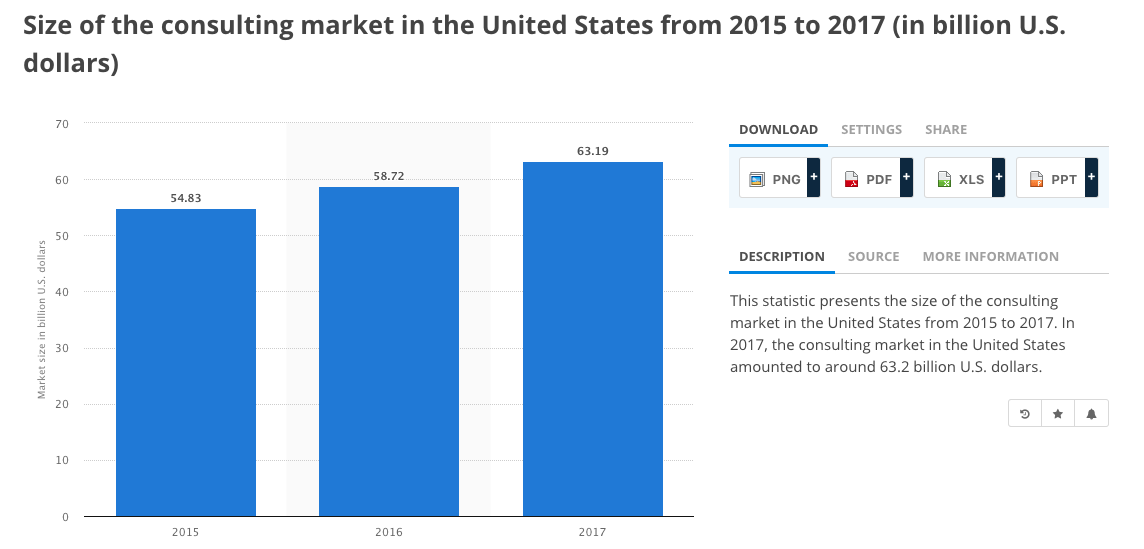

In [6]:
Image(filename = path + "Statista1.png", width=1000, height=1000)

Statista also gave us information on the top consulting firms in the United States. Most (but not all) of these firms have a Data Science consulting branch, but they are all relatively new. This information on the leading consulting firms tells us which firms we should be looking at. Ultimately, we want to be on the top of this list when it comes to Data Science consulting firms, so it's important to gather insights from some of the other top consulting firms. We want to be original in our message and marketing, but looking at the compatition's strategy, growth, and message can help us craft something that's unique and relevant to our customer base. 

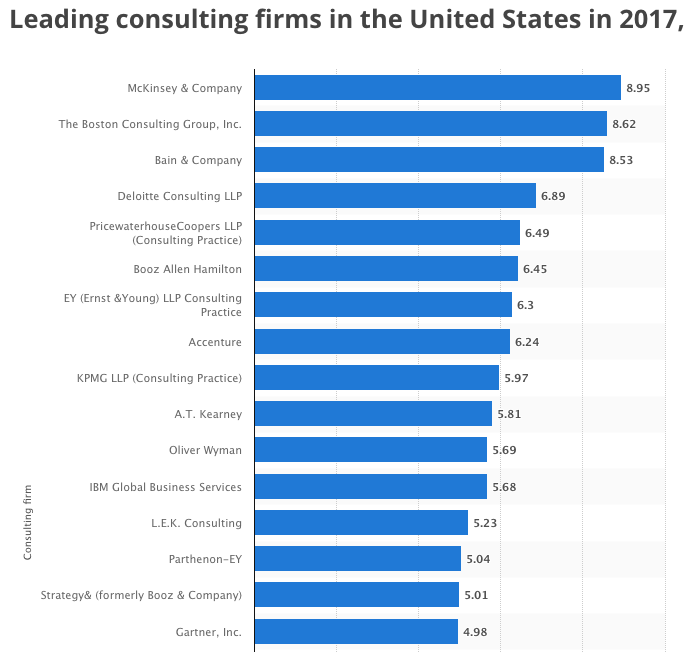

In [7]:
Image(filename = path + "Statista2.png", width=1000, height=1000)

### Forecasting Revenue
Sadly, I couldn't find a related dataset to help me forecast revenue. So, the below analysis mostly intuitive and based on a consultant's capacity. <br><br>

Since we have no previous data, it's difficult to predict our revenues and profits for the coming months and years. However, we can make some assumptions and get a rough idea of what revenue could look like. First, I am going to focus on capacity of our consultants and make a few assumptions about their work habits. <br>

**Assumptions**<br> 
- Christina is going to spend 50% of her time working on projects, and 50% of her time running the business
- Christina knows 3 people that will 100% work for her once she lands her first client
- We are ignoring costs for now and strictly looking at revenue.
- This means Christina has a capacity of 140 hours per week for project work
- Her ideal rate for consulting jobs is $185 per hour
- Christina is not going to hire any new consultants for the first 3 months

**Ideal Scenario**<br>
Consultants are 100% Utilized <br>
140 hours of work per week, for 12 weeks == 1680 working hours in the period
- Revenue for 3 months: $310,800

**More Realistic Scenario**<br>
Consultants are 75% utilized<br>
105 hours of work per week, for 12 weeks == 1260 working hours in the period
- Revenue for 3 months: $233,100

According to Glassdoor, the average salary for a Senior Data Scientist is $190K$ per year. Since Christina is a small business, she is not going to be able to pay her consultants that much. Let's assume she settled on paying her consultants between $120K$ and $150K$ per year (the approximate range for a Data Scientist position in San Francisco).

If her consultants are paid at $150K$ per year, her payroll costs for the first 3 months would be: approximately $112,500$
- Remaining Funds == $120,600

If her consultants are paid at $120K$ per year, her payroll costs for the first 3 months would be: approximately $90K$
- Remaining Funds == $143,100

Once we tack on other costs such as an office space, business fees & taxes, benefits, internet, marketing funds, travel costs, applications (Jira, Slack, Quickbooks, etc.). That revenue start to approach 0 pretty quickly. So, Christina needs to determine if she should raise her hourly rates for the customer, she needs to find ways to keep her consultant's utilization closer to 100%, and needs to attempt to minimze the costs for talent acquisition and customer acquisition. <br><br>
In addition, Christina needs to determine if her company is going to specialize in specific business types or if they will be Data Science generalists. Specializing in specific industries, business types, or business problems allows the firm to scale and become industry experts much quicker. However, this can limit the growth of the firm. <br><br>
If Christina decides to become a generalist, this could allow much more business opportunities. However, constantly adapting and learning new industries / business models can be costly for the business. It's harder to scale and requires consultants that are more senior, which means the costs of her business increase. <br><br>
When we look at the Google Trends section above, we can see clear upward trends in Data Science. To me, this shows that people in the Bay area are showing higher level of interest towards the subject and this could lead to more opportunities for consulting contracts. With this limited analysis, it appears that San Francisco is a great location to start a Data Science Consulting firm. 

### Marketing Events with Meetup.com

https://www.kaggle.com/sirpunch/meetups-data-from-meetupcom#groups.csv

Since I was unable to find a relevant dataset to help me with forecasting, I'm going to look into the potential networking / recruiting / lead generation opportunities with this Meetup dataset. Meetup has grown a lot since its launch and has become extremely popular in the San Francisco Bay Area. Meetups are great opportunities to network with your peers, learn aboutexciting developments within the industry, and connect with likeminded people. When Christina moves to San Francisco, I would highly recommend that she joins Meetup and attends Meetups that are relevant to her business. This could be a low-cost method for potential networking / recruiting / lead generation opportunities. <br>

Below, I am going to do a lot of filtering to get the ideal target numbers for Christina. There are many groups, topics, and members in this dataset. So, we need to filter the dataset down to the members and groups that are going to be most relevant to her. Let's start by reading in the data. 

In [78]:
# Read in relevant files
groups = pd.read_csv('groups.csv')

# Filter the dataset to San Francisco Data only. Note that the values in brackets are IDs for South San Francisco and San Francisco
sf_groups = groups.loc[groups['city_id'].isin([94080, 94101])]

# Filter by Category Short Name
sf_groups = sf_groups.loc[sf_groups['category.shortname'].isin(['career-business', 'education-learning', 'tech'])]

Now that we have filtered the groups data to San Francisco only, let's read in the Topics dataset and filter the data down to a list that's relevant to Christina. 

In [78]:
# Read in the groups_topics dataset
groups_topics = pd.read_csv('groups_topics.csv', encoding='cp1252')

# Merge with groups dataframe
merged = pd.merge(sf_groups, groups_topics, how='left', on='group_id')

# I did a quick browse through the group topics and this is the list I came up with. 
topics = ['business-education', 'business-networking-for-women', 'business-networking-international-bni', 'business-referral-networking', 'business-technology', 
              'business-to-business-network-marketing', 'edtech', 'education', 'emerging-technologies', 'networking-and-professional-development', 
              'networking-for-technology-professionals', 'networking-for-young-professionals', 'newtech', 'professional-and-social-networking', 'professional-bussiness-networking',
              'professional-networking', 'professional-women-networking', 'professional-womens-networking-group', 'science-and-technology', 'science-education', 'science-technology', 
              'science-technology-engineering-math', 'small-and-home-based-business-networking', 'small-business-networking', 'small-business-networking-and-referrals-services', 
              'small-business-technology', 'technology', 'technology-computer-forensics-data-recovery', 'technology-consulting', 'technology-entrepreneurs', 'technology-innovation', 
              'technology-networking', 'technology-professionals', 'technology-security-audits', 'women-business-networking', 'women-science-technology-engineering-mathematics', 
              'womens-business-networking', 'womens-meetup-for-small-business-networking', 'womens-networking']

# Filter by group_topics 
merged = merged.loc[merged['topic_key'].isin(topics)]

Now that we've filtered down the dataset, we can get a general idea of how many professionals that have similar interests in groups for Meetup.com in San Francisco. If this number is large, that would be fantastic. It tells us that not only will we have a large pool of people to network with, but it also gives ample opportunity for recruiting and lead generation. 

In [111]:
# Create list of unique groups from the prior subset
unique_groups = list(merged.group_id.unique())

print('Number of groups in this subset:', len(unique_groups))

Number of groups in this subset: 921


In order to get an accurate reading on the number of members, we need to pull out the group IDs, merge that with the members file, and then count the total number of members in the subset. There is a column in the merged subset for "members," however members can belong to multiple groups. So, if we summed up that column we would definitely be double-triple-quadruple counting members.

In [112]:
# Read in Members DF
members = pd.read_csv('members.csv', encoding='cp1252')

# Filter by group_topics 
members_filtered = members.loc[members['group_id'].isin(unique_groups)]

In [115]:
print('Number of unique members in the groups subset', members_filtered.member_id.nunique())

Number of unique members in the groups subset 125861


This means that there are approximately 125,861 like-minded people in San Francisco's Meetup.com scene. Again, this is a low-cost alternative for Christina to generate leads, recruit new Data Scientists, or help Christina get the name of her business out there. There is also an opportunity for Christina to start her own meetup group, focusing specifically on Data-Science problems and how to solve them. 

### Final Thoughts

While we did not have ideal datasets for this exercise, there are still ample opportunities to get creative and explore the market in San Francisco. With more time, I would spend some (and potentially money) on a jobs dataset that shows both historical and new postings. This would allow me to get a read on the demand for Data Scientists in the San Francisco Bay Area. We could explore the trends, the different job titles, job descriptions, and salary information. This information would not only allow us to predict the demand for a Data Science consultancy in the Bay Area, but we can also begin to understand the supply. <br>

In addition, I would create a simulation dataset that would allow us to more accurately and efficiently predict profits and revenues. If The Data Nerds in Chicago are funding this new venture for Christina, then we would need to go back to them with some hard numbers on what we expect for profit. It may take some time to generate a profit, since the costs of starting up a business can be high. But, if we can show the Data Nerds and Christina that we expect profitibility after xx number of months, that is a convincing argument for Christina to start a new branch in San Francisco. The simulation data would be based on information from the market. <br>

Finally, once we had that simulation data and jobs data, we could begin building models to make predictions about the market. There are many different models to choose from, and we should definitely use cross-validation methods or pre-built model selectors like TPOT to help us determine the best model. Random Forest and other ensemble methods are great ways to show different scenarios, while gradient boosting could be a way for us to work on minimizing the overhead costs (although, this may be overkill this early in the development of the business). Either way, there are many options for us to explore and provide Christina with tangible evidence for her new venture in San Francisco. <br>

Thank you for reading! 